In [2]:
%pip install pandas kagglehub[pandas-datasets] scikit-image matplotlib seaborn
%pip install tensorflow keras scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub

# Download latest version
datapath = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print('dataset path: ' + datapath)

dataset path: C:\Users\Davoleo\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


# Data preparation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io as skio
from skimage import transform as skitrans

train = pd.read_csv(datapath + "\\Train.csv")
test = pd.read_csv(datapath + "\\Test.csv")
meta = pd.read_csv(datapath + "\\Meta.csv")

#print(train.describe())
#print(train.dtypes)

HEIGHT = 32
WIDTH = 32


def load_data(data_csv):

    ims = []
    classes = []

    for t in data_csv.itertuples(index=False):
        # Only use one size
        # if (not t.Path.endswith('00012.png')):
        #     continue

        impath = datapath + '\\' + t.Path
        
        fullim = skio.imread(impath)
        # plt.figure(1)
        # plt.subplot(1,3,1)
        # plt.imshow(fullim)

        # crop on: (Roi.X1, Roi.X2), (Roi.Y1, Roi.Y2)
        # print("crop: ", (t._2, t._4), (t._3, t._5))
        cropim = fullim[t._2:t._4, t._3:t._5]

        # plt.subplot(1,3,2)
        # plt.imshow(cropim)

        finalim = skitrans.resize(cropim, (WIDTH, HEIGHT))
        # plt.subplot(1,3,3)
        # plt.imshow(finalim)

        ims.append(finalim)
        classes.append(t.ClassId)
    
    return (ims, classes)


train_ims, train_class = load_data(train)
print("Training set loaded!!")
test_ims, test_class = load_data(test)
print("Test set loaded!!")

Training set loaded!!
Test set loaded!!


In [18]:
train_x = np.stack(train_ims, axis=0)
train_y = np.array(train_class)

test_x = np.stack(test_ims, axis=0)
test_y = np.array(test_class)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(39209, 32, 32, 3) (39209,)
(12630, 32, 32, 3) (12630,)


In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# Flattening
train_x = train_x.reshape(train_x.shape[0], HEIGHT*WIDTH*3)
# Shuffling
train_x, train_y = shuffle(train_x, train_y, random_state=0)

print("Classes: ", np.unique(train_y))
# One-Hot Encoding
train_y = to_categorical(train_y)

train_x.shape

Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


(39209, 3072)

In [20]:
from tensorflow.keras.utils import to_categorical

test_x_reshaped = test_x.reshape(test_x.shape[0], HEIGHT*WIDTH*3)

print("Classes: ", np.unique(test_y))
hot_test_y = to_categorical(test_y)


test_x_reshaped.shape

Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


(12630, 3072)

# Neural Network

In [72]:
from keras import Sequential
from keras.layers import Dense, Activation, Input
from keras import activations
from keras.utils import set_random_seed

set_random_seed(333)

model = Sequential()

model.add(Input((HEIGHT*WIDTH*3,)))
model.add(Dense(512, activation=activations.relu))
model.add(Dense(256, activation=activations.relu))
model.add(Dense(128, activation=activations.relu))
model.add(Dense(43, activation=activations.softmax))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,743,147 (6.65 MB)

 Trainable params: 1,743,147 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [74]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4327 - loss: 2.1400 - val_accuracy: 0.4629 - val_loss: 2.0600
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6884 - loss: 1.1093 - val_accuracy: 0.6102 - val_loss: 1.4127
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7720 - loss: 0.8079 - val_accuracy: 0.8011 - val_loss: 0.7287
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8267 - loss: 0.6114 - val_accuracy: 0.7624 - val_loss: 0.8206
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8562 - loss: 0.4997 - val_accuracy: 0.8140 - val_loss: 0.6475
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8705 - loss: 0.4447 - val_accuracy: 0.8776 - val_loss: 0.4391
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8896 - loss: 0.3723 - val_accuracy: 0.8393 - val_loss: 0.5678
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8993 - loss: 0.3398 - val_accu

In [75]:
import matplotlib.pyplot as plt

def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

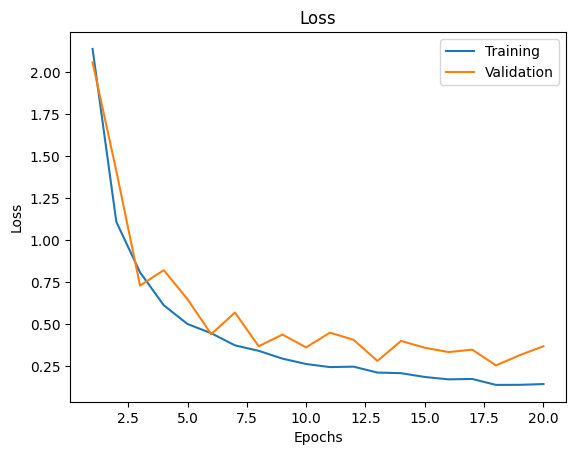

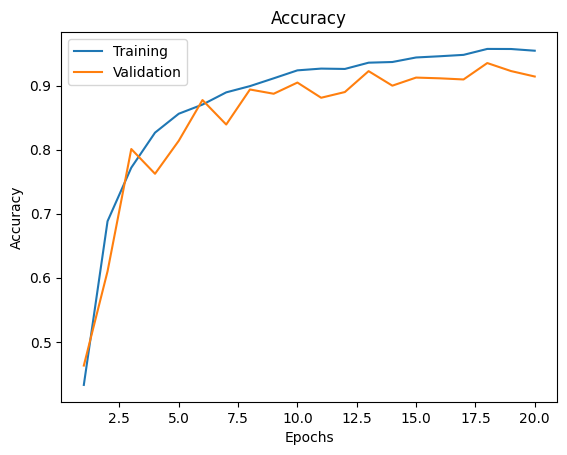

In [76]:
plot_loss(history)
plot_accuracy(history)

In [77]:
loss, precision = model.evaluate(test_x_reshaped, hot_test_y, verbose=1)

# Output Loss / Accuracy of the model after evaluating the model against the test set.
print("\n\nLoss: %6.4f\tAccuracy: %6.4f" % (loss, precision))


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8230 - loss: 1.3376


Loss: 1.3376	Accuracy: 0.8230


In [78]:
prediction = model.predict(test_x_reshaped)
prediction

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        9.8379317e-34, 0.0000000e+00],
       [1.4576100e-06, 9.9999857e-01, 6.1278056e-14, ..., 5.5455745e-22,
        4.0520602e-31, 3.0485202e-24],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.6897176e-17,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.3345170e-07, 1.9768847e-02, 1.9609162e-03, ..., 1.4133285e-05,
        1.3753330e-06, 7.9485457e-03],
       [3.8052275e-04, 1.7861716e-01, 3.1932415e-03, ..., 6.2093303e-02,
        1.2081570e-04, 1.9381881e-02],
       [8.1345503e-10, 1.8213077e-08, 5.9012031e-09, ..., 7.8439399e-07,
        3.0995526e-10, 1.2531896e-11]], shape=(12630, 43), dtype=float32)

## Prediction evaluation

12630 12630
---------
[[ 16  42   0 ...   0   0   0]
 [  0 701   5 ...   0   0   0]
 [  0 167 503 ...   0   0   0]
 ...
 [  0   0   0 ...  57   0   0]
 [  0   0   0 ...   0  55   1]
 [  0   0   0 ...   0   6  82]]
---------
8
13
16
prediction:  26  | real:  18
prediction:  23  | real:  24
prediction:  8  | real:  7


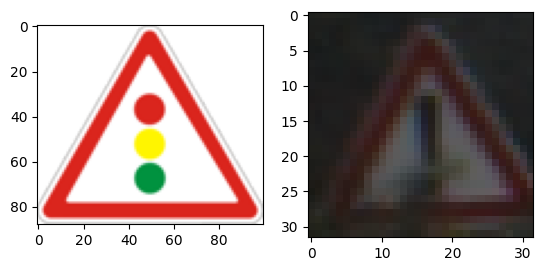

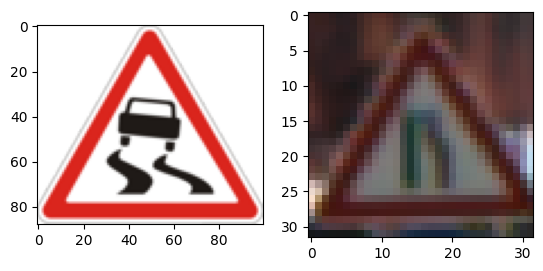

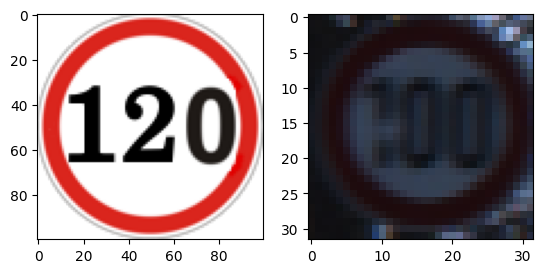

In [91]:
from sklearn.metrics import confusion_matrix

class_predict = np.argmax(prediction, axis=1)

print(len(test_y), len(class_predict))
print("---------")
matrix = confusion_matrix(test_y, class_predict)
print(matrix)
print("---------")

manual_err_idxs = [164, 901, 3828]

err_idxs=[]
i = 0
while (len(err_idxs) < 3 and i < len(class_predict)):
	if (class_predict[i] != test_y[i]):
		print(i)
		err_idxs.append(i)
	i = i + 1

for idx in manual_err_idxs:
	print("prediction: ", class_predict[idx], " | real: ", test_y[idx])
	plt.figure()
	plt.subplot(1,2,1)
	metaitem = meta[meta.ClassId == class_predict[idx]]
	meta_im = skio.imread(datapath + "\\" + metaitem['Path'].values[0])
	plt.imshow(meta_im)
	plt.subplot(1,2,2)
	plt.imshow(test_x[idx])

### Confusion Matrix

salofa


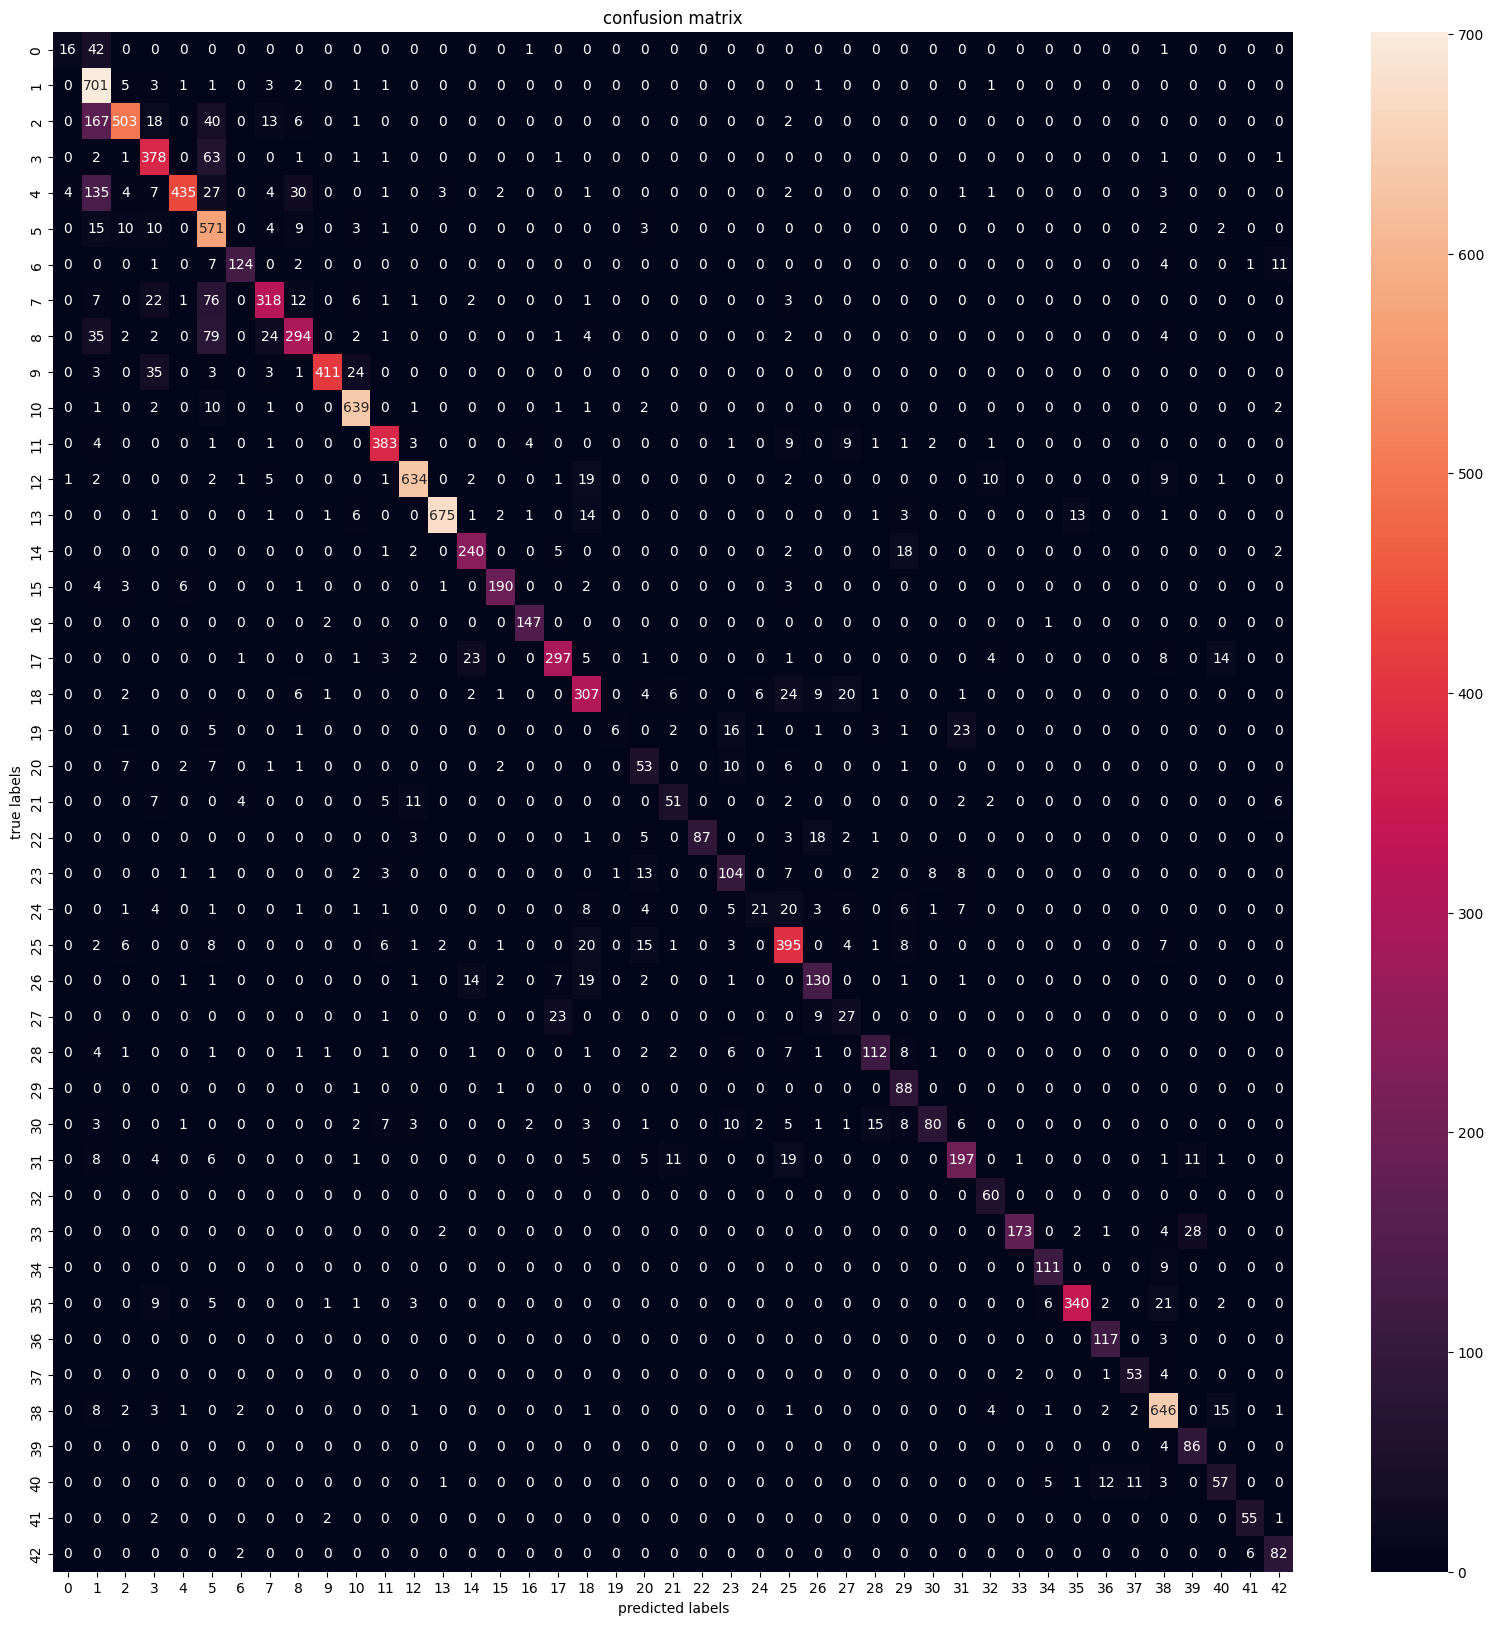

In [80]:
import seaborn as sns

# Confusion matrix heatmap
plt.figure(figsize=(20,20))
labels = np.unique(test_y)
ax=plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt=',d')
ax.set_xlabel("predicted labels")
ax.set_ylabel("true labels")
ax.set_title("confusion matrix")
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

print("salofa")